# Build MMM with PyMC library

In [22]:
# import library required
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import random

In [23]:
# import dataset
df = pd.read_csv('/Users/gytkd/Desktop/김효상/job-hunting/interview/haensel/MMM_test_data.csv') 
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_of_week    104 non-null    object 
 1   revenue          104 non-null    float64
 2   spend_channel_1  104 non-null    float64
 3   spend_channel_2  104 non-null    float64
 4   spend_channel_3  104 non-null    float64
 5   spend_channel_4  104 non-null    float64
 6   spend_channel_5  104 non-null    float64
 7   spend_channel_6  104 non-null    float64
 8   spend_channel_7  104 non-null    float64
dtypes: float64(8), object(1)
memory usage: 7.4+ KB


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


### Features
* start_of_week: sunday-saturday is one week
* revenue: the total amount of income generated by the sale of goods and services from a company 
* spend channel: 7 different channels for marketing campaign/ads

In [24]:
# Prepare input to model
spend_columns = [f'spend_channel_{i}' for i in range(1, 8)]
spend = df[spend_columns].values 
revenue = df['revenue'].values

### Seasonality and trend variables

In [25]:
# Deifne the seasonality and trend related variables
# Time
time = np.arange(len(revenue))

# Ensure spend is a 2D array with shape (time frame, channels)
# spend.shape[0] == number of rows, spend.shape[1] == number of channels
if spend.ndim == 1:
    spend = spend[:, np.newaxis]

# Define the number of Fourier terms for seasonality
num_fourier_terms = 2  # initial value = 2

### Posterior sampling function to define the best fourier terms

In [26]:
# Function to build and evaluate the model for the num_fourier_terms selection
def build_and_evaluate_model(num_fourier_terms):
    with pm.Model(coords={"obs": np.arange(104)}) as model:
        
        # Priors for unknown model parameters
        # residual
        alpha = pm.Normal('alpha', mu=0, sigma=1)
        # coefficients for the spend channels variables
        beta = pm.Normal('beta', mu=0, sigma=1, shape=spend.shape[1])
        # spend carry over rate in Beta distribution
        carryover_rate = pm.Beta('carryover_rate', alpha=3, beta=3, shape=spend.shape[1])
        
        # Trend components
        trend_beta = pm.Normal('trend_beta', mu=0, sigma=1)
        trend = trend_beta * time
        
        # Seasonality components
        fourier_terms = []
        for k in range(1, num_fourier_terms + 1):
            cos_term = pm.Normal(f'cos_term_{k}', mu=0, sigma=1)
            sin_term = pm.Normal(f'sin_term_{k}', mu=0, sigma=1)
            fourier_terms.append(cos_term * np.cos(2 * np.pi * k * time / len(revenue)))
            fourier_terms.append(sin_term * np.sin(2 * np.pi * k * time / len(revenue)))
        seasonality = sum(fourier_terms)
        
        # Initialize carryover spend array
        carryover_spend = np.zeros_like(spend)
        
        # Calculate carryover spend
        for t in range(1, spend.shape[0]):
            carryover_spend[t] = spend[t] + carryover_rate.eval() * carryover_spend[t-1]
        
        # Expected revenue
        mu = alpha + trend + seasonality + pm.math.dot(carryover_spend, beta)
        
        # Likelihood of observations
        sigma = pm.HalfNormal('sigma', sigma=1)
        observed = pm.Normal('observed', mu=mu, sigma=sigma, observed=revenue, dims=["obs"])
        
        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True, idata_kwargs={"log_likelihood": True}, random_seed = 0)
           

    # Calculate WAIC and LOO
    waic = az.waic(trace)
    loo = az.loo(trace)
    
    return waic, loo, trace

### Define 'fourier terms'

In [27]:
# Evaluate models with different numbers of Fourier terms
np.random.seed(42)
results = []
for num_terms in range(1, 6):  # Test from 1 to 5 Fourier terms
    waic, loo, trace = build_and_evaluate_model(num_terms)
    results.append((num_terms, waic.waic, loo.loo))


# Print results
for num_terms, waic_val, loo_val in results:
    print(f"Number of Fourier Terms: {num_terms}, WAIC: {waic_val:.2f}, LOO: {loo_val:.2f}")

# Choose the model with the lowest WAIC or LOO
best_num_terms = min(results, key=lambda x: x[1])[0]
print(f"Best number of Fourier terms: {best_num_terms}")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, carryover_rate, trend_beta, cos_term_1, sin_term_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Number of Fourier Terms: 1, WAIC: -265718.01, LOO: -234692.54
Number of Fourier Terms: 2, WAIC: -272672.77, LOO: -242303.03
Number of Fourier Terms: 3, WAIC: -262006.83, LOO: -232894.59
Number of Fourier Terms: 4, WAIC: -266202.99, LOO: -233758.06
Number of Fourier Terms: 5, WAIC: -261796.20, LOO: -232681.16
Best number of Fourier terms: 2


/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/gytkd/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


### Modelling with posterior sampling

In [18]:
with pm.Model(coords={"obs": np.arange(104)}) as model:
        
    # Priors for unknown model parameters
    # residual
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=spend.shape[1])
    carryover_rate = pm.Beta('carryover_rate', alpha=3, beta=3, shape=spend.shape[1])
        
    # Trend components
    trend_beta = pm.Normal('trend_beta', mu=0, sigma=1)
    trend = trend_beta * time
        
    # Seasonality components
    fourier_terms = []
    for k in range(1, best_num_terms + 1): #best_num_terms = 1
        cos_term = pm.Normal(f'cos_term_{k}', mu=0, sigma=1)
        sin_term = pm.Normal(f'sin_term_{k}', mu=0, sigma=1)
        fourier_terms.append(cos_term * np.cos(2 * np.pi * k * time / len(revenue)))
        fourier_terms.append(sin_term * np.sin(2 * np.pi * k * time / len(revenue)))
    seasonality = sum(fourier_terms)
        
    # Initialize carryover spend array
    carryover_spend = np.zeros_like(spend)
        
    # Calculate carryover spend
    for t in range(1, spend.shape[0]):
        carryover_spend[t] = spend[t] + carryover_rate.eval() * carryover_spend[t-1]
        
    # Expected revenue
    mu = alpha + trend + seasonality + pm.math.dot(carryover_spend, beta)
    
    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    observed = pm.Normal('observed', mu=mu, sigma=sigma, observed=revenue,  dims=["obs"])
    
    # Sample from the posterior with a random seed
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=0, idata_kwargs={"log_likelihood": True}, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, carryover_rate, trend_beta, cos_term_1, sin_term_1, cos_term_2, sin_term_2, cos_term_3, sin_term_3, cos_term_4, sin_term_4, cos_term_5, sin_term_5, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


### Performance of posterior-sampled model

                      mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   
alpha                0.834  0.999   -1.025    2.750      0.015    0.014  \
beta[0]             -3.630  0.046   -3.714   -3.541      0.001    0.001   
beta[1]             10.855  0.242   10.439   11.343      0.004    0.003   
beta[2]              0.654  0.006    0.642    0.665      0.000    0.000   
beta[3]              1.402  0.018    1.370    1.436      0.000    0.000   
beta[4]              1.446  0.007    1.433    1.458      0.000    0.000   
beta[5]              1.615  0.008    1.599    1.631      0.000    0.000   
beta[6]              0.494  0.004    0.487    0.502      0.000    0.000   
trend_beta         -20.807  0.984  -22.668  -18.963      0.013    0.009   
cos_term_1           0.806  0.990   -1.101    2.580      0.016    0.013   
sin_term_1          -0.163  1.037   -2.145    1.763      0.015    0.017   
cos_term_2           0.530  1.002   -1.354    2.422      0.014    0.014   
sin_term_2           1.53

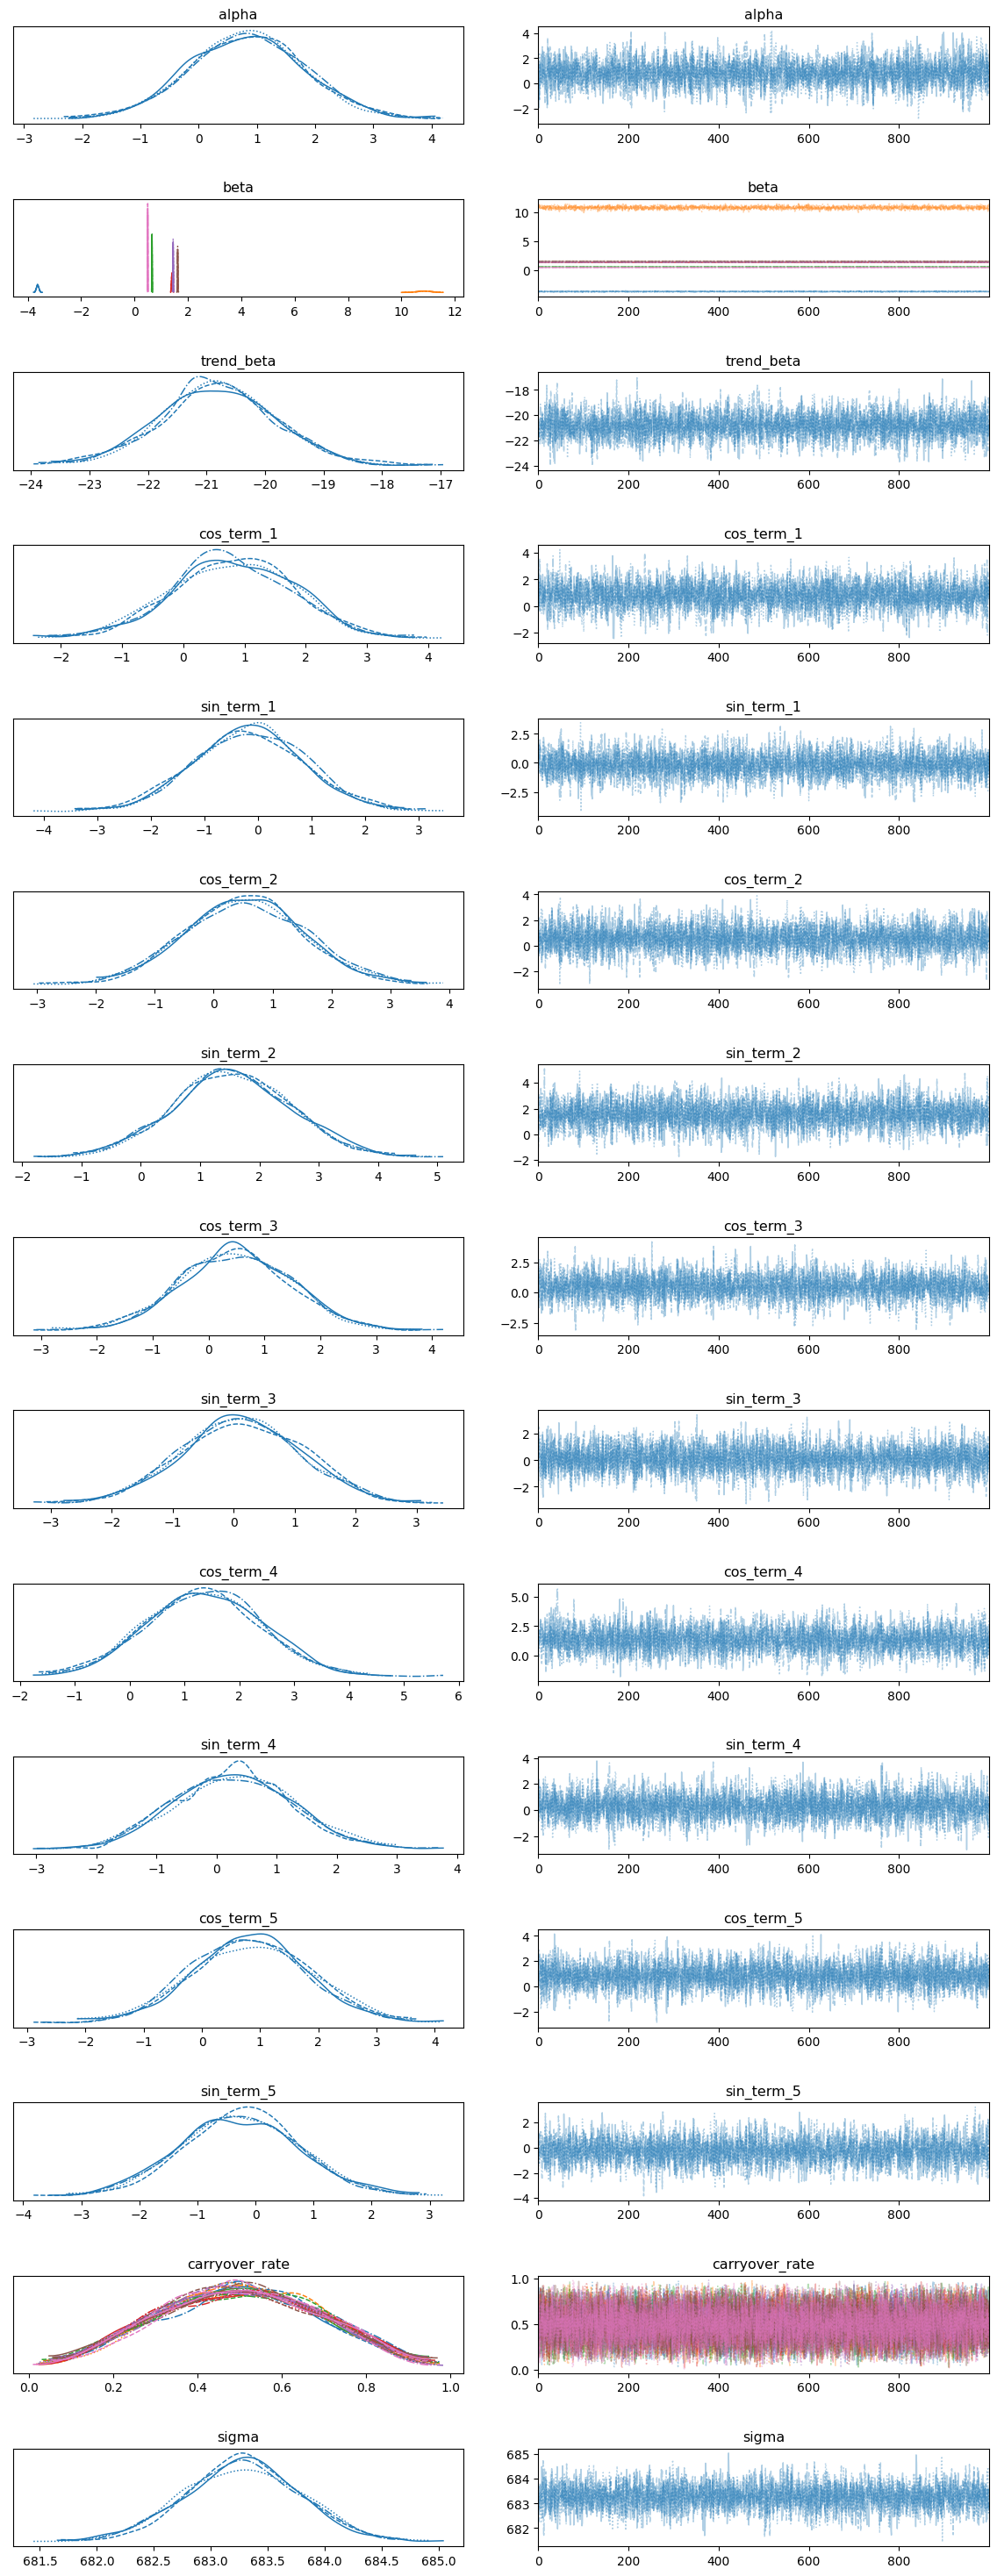

Sampling: [observed]


<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1000, obs: 104)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * obs       (obs) int64 0 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
Data variables:
    observed  (chain, draw, obs) float64 993.7 5.267e+04 ... 9.77e+04 9.028e+04
Attributes:
    created_at:                 2024-06-17T18:45:15.529574
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  5.12.0


/Users/gytkd/miniforge3/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


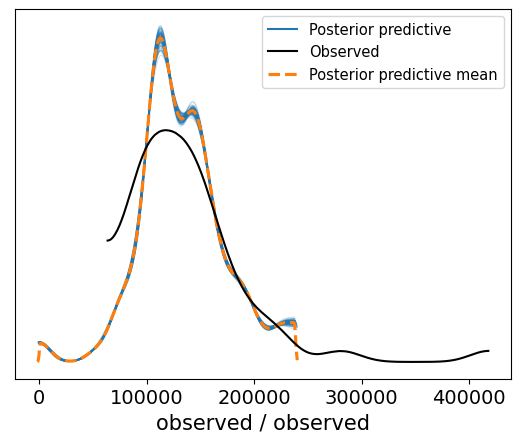

In [19]:
# plot the result of trace and ppc
with model:
    # trace summary 
    post_trace_summary = az.summary(trace)
    print(post_trace_summary)
    # trace plot
    az.plot_trace(trace)
    plt.tight_layout(pad=3.0)
    plt.show()
    # ppc
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=0)
    print(trace.posterior_predictive)
    az.plot_ppc(trace, num_pp_samples=100);

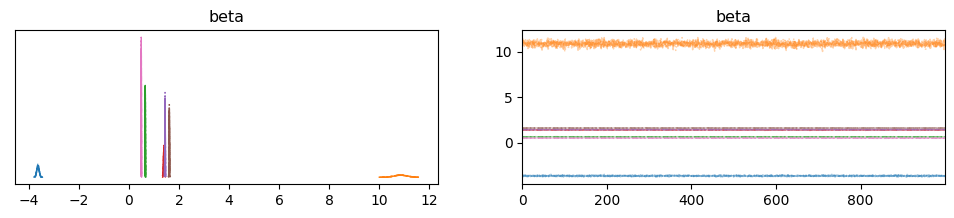

In [20]:
# check the effect of each channel to the spend carry over
with model: 
    az.plot_trace(trace, var_names='beta')  

### Prior Sampling

Sampling: [alpha, beta, carryover_rate, cos_term_1, cos_term_2, cos_term_3, cos_term_4, cos_term_5, observed, sigma, sin_term_1, sin_term_2, sin_term_3, sin_term_4, sin_term_5, trend_beta]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, carryover_rate, trend_beta, cos_term_1, sin_term_1, cos_term_2, sin_term_2, cos_term_3, sin_term_3, cos_term_4, sin_term_4, cos_term_5, sin_term_5, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


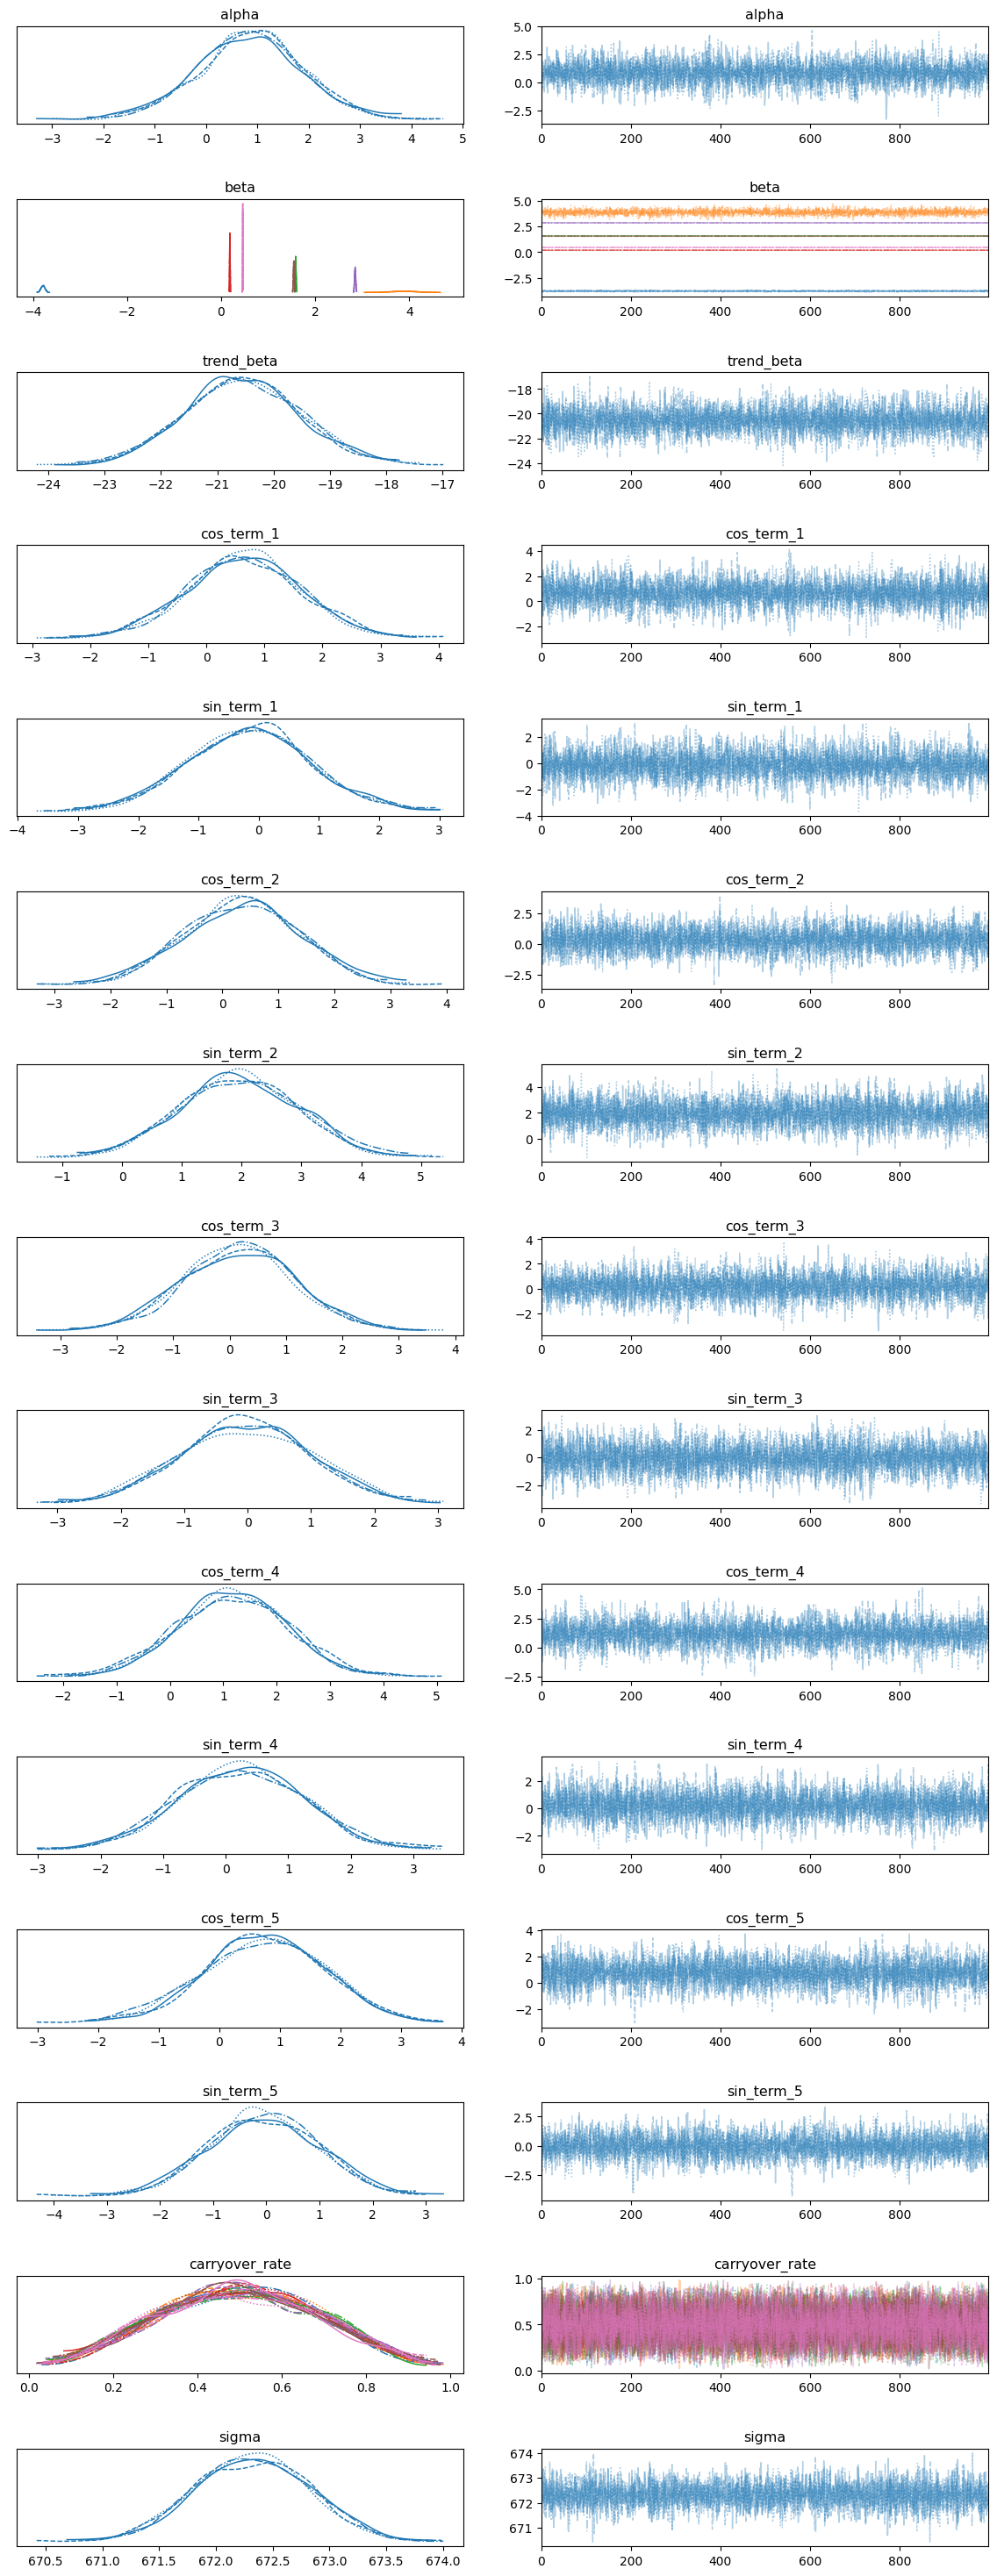

In [21]:
with pm.Model(coords={"obs": np.arange(104)}) as model:
        
    # Priors for unknown model parameters
    # residual
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=spend.shape[1])
    carryover_rate = pm.Beta('carryover_rate', alpha=3, beta=3, shape=spend.shape[1])
        
    # Trend components
    trend_beta = pm.Normal('trend_beta', mu=0, sigma=1)
    trend = trend_beta * time
        
    # Seasonality components
    fourier_terms = []
    for k in range(1, best_num_terms + 1): #best_num_terms = 1
        cos_term = pm.Normal(f'cos_term_{k}', mu=0, sigma=1)
        sin_term = pm.Normal(f'sin_term_{k}', mu=0, sigma=1)
        fourier_terms.append(cos_term * np.cos(2 * np.pi * k * time / len(revenue)))
        fourier_terms.append(sin_term * np.sin(2 * np.pi * k * time / len(revenue)))
    seasonality = sum(fourier_terms)
        
    # Initialize carryover spend array
    carryover_spend = np.zeros_like(spend)
        
    # Calculate carryover spend
    for t in range(1, spend.shape[0]):
        carryover_spend[t] = spend[t] + carryover_rate.eval() * carryover_spend[t-1]
        
    # Expected revenue
    mu = alpha + trend + seasonality + pm.math.dot(carryover_spend, beta)
    
    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    observed = pm.Normal('observed', mu=mu, sigma=sigma, observed=revenue,  dims=["obs"])
    
    #sample from the prior
    trace = pm.sample_prior_predictive(50, random_seed = 0)
    
with model:
    trace.extend(pm.sample(1000, tune=2000, random_seed=0))


az.plot_trace(trace);
plt.tight_layout(pad=3.0)
plt.show()
    